In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [12]:
# 訓練用とテスト用のデータパスを設定する
train_data_path = '/home/jovyan/work/1/data/data/cats_and_dogs/train'
test_data_path = '/home/jovyan/work/1/data/data/cats_and_dogs/validation'

In [13]:
# 精度が95%に達したら訓練を停止するカスタムコールバック関数
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.95):
            print("\n95%の精度に達したため訓練をキャンセルします！")
            self.model.stop_training = True

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# テストデータにはデータ拡張を適用しない
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
# データ生成器を作成
train_generator = train_datagen.flow_from_directory(
    train_data_path,             # トレーニングデータのフォルダパス
    target_size=(150, 150),      # 画像のリサイズ後のサイズ
    batch_size=32,
    class_mode='binary'          # 2値分類
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

print(train_generator.class_indices)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}


In [16]:
# ResNet50モデルを事前学習済みの重みで読み込み、トップレイヤーを含まない形で設定
pre_trained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
pre_trained_model.trainable = False  # 事前学習済みの層の重みは固定

2024-08-03 02:12:08.759668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:56:00.0, compute capability: 8.0


In [17]:
# カスタム層の追加
x = GlobalAveragePooling2D()(pre_trained_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

In [18]:
# 新しいモデルを構築
model = Model(inputs=pre_trained_model.input, outputs=x)
# モデルをコンパイル
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [19]:
# モデルを訓練
callbacks = myCallback()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    verbose=2,
    callbacks=[callbacks]
)

# モデルを保存
model.save('model4.h5')

Epoch 1/100


2024-08-03 02:12:14.129083: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-08-03 02:12:17.966573: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff4b84326b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-03 02:12:17.966604: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.10gb, Compute Capability 8.0
2024-08-03 02:12:17.971491: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1722651138.078290   51075 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 - 20s - loss: 0.7345 - acc: 0.5255 - val_loss: 0.6837 - val_acc: 0.5430 - 20s/epoch - 324ms/step
Epoch 2/100
63/63 - 10s - loss: 0.7025 - acc: 0.5295 - val_loss: 0.6738 - val_acc: 0.5750 - 10s/epoch - 158ms/step
Epoch 3/100
63/63 - 10s - loss: 0.6871 - acc: 0.5535 - val_loss: 0.7071 - val_acc: 0.5320 - 10s/epoch - 158ms/step
Epoch 4/100
63/63 - 10s - loss: 0.6847 - acc: 0.5575 - val_loss: 0.6666 - val_acc: 0.5930 - 10s/epoch - 159ms/step
Epoch 5/100
63/63 - 10s - loss: 0.6779 - acc: 0.5670 - val_loss: 0.6650 - val_acc: 0.5970 - 10s/epoch - 159ms/step
Epoch 6/100
63/63 - 10s - loss: 0.6795 - acc: 0.5690 - val_loss: 0.6991 - val_acc: 0.5030 - 10s/epoch - 159ms/step
Epoch 7/100
63/63 - 10s - loss: 0.6734 - acc: 0.5805 - val_loss: 0.6596 - val_acc: 0.6170 - 10s/epoch - 159ms/step
Epoch 8/100
63/63 - 10s - loss: 0.6877 - acc: 0.5495 - val_loss: 0.6649 - val_acc: 0.5970 - 10s/epoch - 158ms/step
Epoch 9/100
63/63 - 10s - loss: 0.6708 - acc: 0.5805 - val_loss: 0.6775 - val_acc: 0.5480 - 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


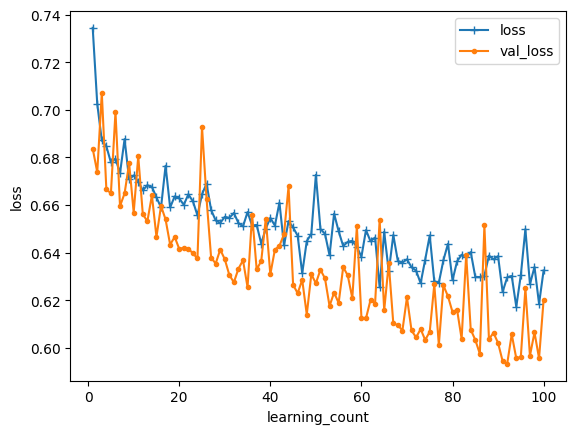

In [20]:
# 绘制损失图表
loss = history.history['loss']
val_loss = history.history['val_loss']

learning_count = len(loss) + 1

plt.plot(range(1, learning_count),loss,marker='+',label='loss')
plt.plot(range(1, learning_count),val_loss,marker='.',label='val_loss')
plt.legend(loc = 'best', fontsize=10)
plt.xlabel('learning_count')
plt.ylabel('loss')
plt.show()

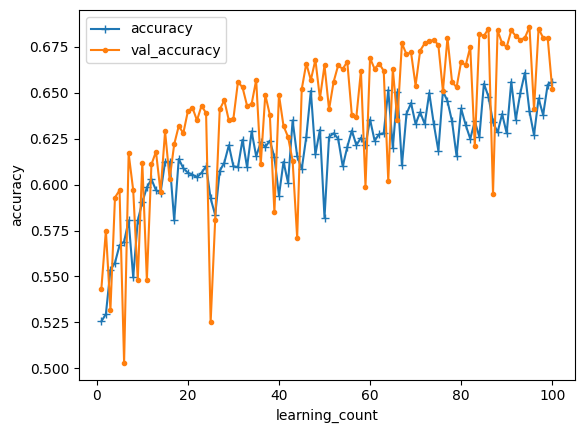

In [22]:
# 绘制准确率图表
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

plt.plot(range(1, learning_count),accuracy,marker='+',label='accuracy')
plt.plot(range(1, learning_count),val_accuracy,marker='.',label='val_accuracy')
plt.legend(loc = 'best', fontsize=10)
plt.xlabel('learning_count')
plt.ylabel('accuracy')
plt.show()